# Handout #5: Unsupervised Learning (optimization-based clustering)

## Problem 7

### Definition of the clustering function

Using almost the same code, we will develop two clustering functions. 
One for *crisp* and other for *fuzzy* clustering.

In [1]:
# Import the needed libraries
#
import numpy as np
import random

In [2]:
# Supported methods
#
METHODS = {'crisp': 1, 'fuzzy': 2}

# Avoid divide by zero at 
# - membership matrix (U) calc
# - cluster radius (theta) calc
#
EPS_DIV0 = 1e-9

In [3]:
def proximity_sense():
    # if the proximity function is a 
    # - dissimilarity metric (DM), must return the reference to the minimum function
    # - simillarity metric (SM), must return the reference to the maximum function
    
    # in this exercise we are working with a distance, 
    # that is a dissimilarity metric, so this function must
    # return the min() function
    
    return min


def get_best_value(vector: np.ndarray) -> float:
    # returns the best value from numpy 'vector'
    
    # will get the minimum or maximum value 
    # according to the DM or SM
    #
    sense_func = proximity_sense()
    best_value = sense_func(vector)
    
    return best_value


def get_best_index_from(vector: np.ndarray) -> int:
    # returns the (first) position (zero indexed) of 
    # the minimum value or maximum value
    # that cotains 'vector' array
    
    if type(vector) != np.ndarray: 
        raise TypeError("'vector' must be a numpy array")
        
    best_position = np.where(vector == get_best_value(vector))[0][0]
    
    return best_position    

In [4]:
def get_initial_thetas(X: np.ndarray, M: int) -> np.ndarray:
    # returns a random matrix of cluster definitions
    
    # test if we have sufficient datapoints
    #
    n_datapoints = len(X)
    
    if n_datapoints < M:
        raise ValueError("Insufficient number of datapoints")
    
    
    # as we can define the cluster by its radius (an scalar),
    # the matrix shape is M x 1
    # where M is the number of desired clusters
    #
    # to compute the cluster's radius, 
    # will select M random datapoints and use 
    # its radius (distance to origin) as the cluster's one
    # 
    # we think its a very fast initialization method, 
    # but the drawback is that is not assured that
    # the M selected values have an uniform distribution
    # over the radius value space
    # we also verify that there aren't repeated values
    #

    # force the first cluster to zero radius
    # to get a bigger centroids initial radius difference 
    # and avoid an early stop at first loop
    #
    radius_list = list([[0.]])
    
    # search a radius value for the rest of centroids
    #
    for j in range(1, M):
        rand_index = random.randint(a=0, b=n_datapoints - 1)
        radius = np.linalg.norm(X[rand_index])
        while radius in radius_list:
            rand_index = random.randint(a=0, b=n_datapoints - 1)
            radius = np.linalg.norm(X[rand_index])
        radius_list.append([radius])
    
    # sort list to try to get clusters ordered by their radius
    #
    radius_list.sort()
    
    thetas = np.array(radius_list, dtype=float)
    
    return thetas

In [5]:
def proximity_func(datapoint: np.ndarray, theta: np.ndarray) -> float:
    # return the squared distance between 
    # 'datapoint' and cluster radius
    #
    # 'theta' is a ... say 'one dimension vector' 
    # containing cluster radius,
    # cause only the radius is needed to describe the cluster
    # due to it's centered at axes origin
    
    datapoint_norm = np.linalg.norm(datapoint)
    
    distance1 = datapoint_norm - theta[0]
    distance2 = distance1 * distance1 
    
    return distance2


def calc_membership_at(datapoint: np.ndarray, cluster_num: int, thetas: np.ndarray, 
                       method: str, q: float) -> float:
    # return membership level of a datapoint to 'cluster_num'
    # according to the proximity values that 'vector' cotains

    if not(type(q) in [float, int] and q > 1):
        raise ValueError("fuzzifier 'q' value must be greater than 1")

    n_clusters = len(thetas)
    
    if METHODS.get(method) == 1:  # 'crisp'
        
        proximity_vector = np.empty(n_clusters, dtype=float)
        
        # populate proximity_vector
        #
        for j in range(n_clusters):
            proximity_vector[j] = proximity_func(
                datapoint=datapoint, theta=thetas[j])
        
        best_value = get_best_value(proximity_vector)
        
        if cluster_num == np.where(proximity_vector == best_value)[0][0]:
            level = 1
        else:
            level = 0
            
    elif METHODS.get(method) == 2:  # 'fuzzy'
        
        sigma = 0.
        
        for k in range(n_clusters):
            
            proximity_ij = proximity_func(datapoint=datapoint, theta=thetas[cluster_num])
            proximity_ik = proximity_func(datapoint=datapoint, theta=thetas[k])
            ratio = EPS_DIV0 + proximity_ij / (EPS_DIV0 + proximity_ik)  # avoid DIV/0
            ratio_q = ratio ** (1 / (q - 1))
            
            sigma += ratio_q
        
        level = 1 / sigma
            
    else:
        raise ValueError("clustering method is not supported")
    
    return level


def calc_membership(X: np.ndarray, thetas: np.ndarray, method: str, q: float) -> np.ndarray:
    # return membership array
    #
    
    n_datapoints = len(X)
    n_clusters = len(thetas)
    
    if METHODS.get(method) == 1:  # 'crisp'
        U = np.empty((n_datapoints, n_clusters), dtype=int)
    else:
        U = np.empty((n_datapoints, n_clusters), dtype=float)
    
    for i in range(n_datapoints):
        
        # compute membership
        #
        for j in range(n_clusters):
            
            value = calc_membership_at(
                datapoint=X[i], cluster_num=j, thetas=thetas, 
                method=method, q=q)
            U[i, j] = value
    
    return U
    

def calc_cost_value(X: np.ndarray, M:int, U: np.ndarray, thetas: np.ndarray, 
                    method: str, q: float) -> float:
    # return the cost function value
    #
    
    n_datapoints = len(X)
    
    cost_value = 0.
    
    for i in range(n_datapoints):
        
        for j in range(M):
            
            if METHODS.get(method) == 1:
                u_ij_q = U[i, j]
            else:
                u_ij_q = U[i, j] ** q

            proximity = proximity_func(X[i], thetas[j])
            cost_value += u_ij_q * proximity
    
    return cost_value

In [6]:
def calc_cluster_radius(cluster_num: int, X: np.ndarray, U: np.ndarray, 
                        method: str, q: float) -> float:
    # return the (next) cluster radius
    #
    
    if not(type(method) == str and method in METHODS): 
        raise ValueError("invalid specified 'method'")

    n_datapoints = len(X)
    
    momentum = 0.
    weight = 0.
        
    for i in range(n_datapoints):
        
        if METHODS.get(method) == 1:  # 'crisp'
            u_ij_q = U[i, cluster_num]
        else:  # 'fuzzy' assumed
            u_ij_q = U[i, cluster_num] ** q

        x_i = X[i]
        x_i_norm = np.linalg.norm(x_i)
        momentum += u_ij_q * x_i_norm
        weight += u_ij_q
            
    radius = momentum / (EPS_DIV0 + weight)
    
    return radius


def calc_thetas(X: np.ndarray, M: int, U: np.ndarray, 
                method: str, q: float) -> np.ndarray:
    # return new clusters definition array (thetas)
    # based on actual membership values
    
    n_datapoints = len(X)
    theta_list = list()
    
    for j in range(M):
        
        radius = calc_cluster_radius(
            cluster_num=j, X=X, U=U, method=method, q=q)

        theta_list.append([radius])
    
    thetas = np.array(theta_list, dtype=float)
                    
    return thetas

In [7]:
def calc_thetas_distance(new_thetas: np.ndarray, old_thetas: np.ndarray) -> float:
    # return the euclidean distance between 
    # cluster definition vectors 
    # (the theta vectors)
    
    thetas_delta = (new_thetas - old_thetas)
    distance = np.linalg.norm(thetas_delta)
    
    return distance


def get_cluster_labels(U: np.ndarray) -> np.ndarray:
    # return the obtained clustering labels
    #

    labels_list = list()
    
    for tupl in U:
        
        label = np.argmax(tupl)
        labels_list.append(label)
        
    labels = np.array(labels_list, dtype=int)
    
    return labels

In [8]:
def do_clustering(X: np.ndarray, M: int, n_iter: int , n_attempts: int, eps: float, 
                  method: str='crisp', q: float=2.0) -> list:
    # X: datapoints to classify
    # M: number of desired clusters
    # n_iter: maximum number of iterations per attempt
    # n_attempts: maximum number of attempts
    # eps: stopping delta value
    # method: the desired methodology, 
    #     valid values are  'crisp' and 'fuzzy'
    # q: the fuzzifier coeficient (in case 'fuzzy' method is selected)
    #
    # returns the best clusters labels list,
    # the best cluster theta vector and
    # the best cost value history
    # from the best attempt
    
    # CONSTANTS
    #
    LABELS_FIELD = 'cluster_labels'
    THETAS_FIELD = 'theta_vector'
    COST_HIST_FIELD = 'cost_history'
    BEST_COST_FIELD = 'best_cost'
    
    # VARIABLES
    #
    
    # an empty list to store each attempt
    #
    attempt_list = list()
    
    for attempt in range(n_attempts):
        
        # theta values initialization
        #
        thetas = get_initial_thetas(X=X, M=M)
        
        # cost function value history vector
        #
        cost_value_history = np.empty(0, dtype=float)
        
        # delta criteria finalization
        #
        delta = eps

        # iterations counter
        #
        it = 0

        # will iterate until n_iterations are exhausted or 
        # cost function value variation is above epsilon value
        #
        while it < n_iter and delta >= eps:
            
            # calc membership matrix
            #
            U = calc_membership(
                X=X, thetas=thetas,
                method=method, q=q)
            
            # calculate next clusters centroids
            #
            old_thetas = thetas
            thetas = calc_thetas(
                X=X, M=M, U=U, method=method, q=q)
            
            # calculate thetas delta
            #
            delta = calc_thetas_distance(
                new_thetas=thetas, 
                old_thetas=old_thetas)
                       
            # calculate cost function value
            #
            cost_value = calc_cost_value(
                X=X, M=M, U=U, thetas=thetas, method=method, q=q)
            
            cost_value_history = np.append(
                cost_value_history, cost_value)
            
            # go to next try
            #
            it += 1
        
        # save results
        #
        best_cost_value = get_best_value(
            vector=cost_value_history)
        
        cluster_labels = get_cluster_labels(U=U)
        
        new_entry = {
            LABELS_FIELD: cluster_labels,
            THETAS_FIELD: thetas,
            COST_HIST_FIELD: cost_value_history,
            BEST_COST_FIELD: best_cost_value
        }
        
        attempt_list.append(new_entry)
        
    # Select the best attempt
    #
    best_cost_value = None

    for attempt_entry in attempt_list:

        if best_cost_value is None or get_best_index_from(np.array([attempt_entry[BEST_COST_FIELD], best_cost_value])) == 0:
            
            best_cluster_labels = attempt_entry[LABELS_FIELD]
            best_theta_vector = attempt_entry[THETAS_FIELD]
            best_cost_value_history = attempt_entry[COST_HIST_FIELD]
            best_cost_value = attempt_entry[BEST_COST_FIELD]
            
    return best_cluster_labels, best_theta_vector, best_cost_value_history, best_cost_value

In [9]:
def do_crisp_clust(X: np.ndarray, M: int, n_iter: int, n_attempts: int, eps: float) -> list:
    # X: datapoints to classify
    # M: number of desired clusters
    # n_iter: maximum number of iterations per attempt
    # n_attempts: maximum number of attempts
    # eps: stopping delta value
    #
    # returns the best clusters labels list,
    # the best cluster theta vector and
    # the best cost value history
    # from the best attempt
    
    li = do_clustering(
        X=X, M=M, n_iter=n_iter, n_attempts=n_attempts, eps=eps)
    
    return li

In [10]:
def do_fuzzy_clust(X: np.ndarray, M: int, n_iter: int, n_attempts: int, eps: float, q: float) -> list:
    # X: datapoints to classify
    # M: number of desired clusters
    # n_iter: maximum number of iterations per attempt
    # n_attempts: maximum number of attempts
    # eps: stopping delta value
    # q: the fuzzifier coeficient
    #
    # returns the best clusters labels list,
    # the best cluster theta vector and
    # the best cost value history
    # from the best attempt
    # using Fuzzy c-Means algorithm
    
    li = do_clustering(
        X=X, M=M, n_iter=n_iter, n_attempts=n_attempts, eps=eps, 
        method='fuzzy', q=q)
    
    return li

### Load the *dataset*

Our group is '01'.

In [11]:
group = '01'  # BERNAT LADARIA, Lluís
ds = 7

Load vectors from file.

In [12]:
data = np.loadtxt('ds'+group+str(ds)+'.txt')

Split data and labels.

In [13]:
X = data[:, 0:2]
y = data[:, 2]

How many vectors we have to classify?

In [14]:
X.shape

(300, 2)

How many classes?

In [15]:
y_classes = np.unique(y)
y_classes

array([0., 1., 2.])

We have a 3 classes classification problem.

### Cluster the data

Import necessary functions and classes.

In [16]:
from sklearn.metrics import v_measure_score
from sklearn.metrics.cluster import contingency_matrix

In [17]:
import itertools
import matplotlib.pyplot as plt
import matplotlib.colors as col

Initialization.

In [18]:
M = 3
n_iter = 20
n_attempts = 5
eps = 1e-3

In [19]:
SEED = 42

#### Crisp clustering

Now will try if it works.
The crisp clustering is a good starting point.

Fix a random seed for an easier debugging

In [20]:
random.seed(SEED)

In [21]:
[best_cluster_labels, best_theta_vector, cost_value_history, best_cost_value] = \
    do_crisp_clust(X=X, M=M, n_iter=n_iter, n_attempts=n_attempts, eps=eps)

In [22]:
def print_report(best_cluster_labels, best_theta_vector, cost_value_history, best_cost_value):
    print("Obtained clustering labels frequencies:", np.unique(best_cluster_labels, return_counts=True))
    print("Obtained clustering definitons (radius):", best_theta_vector.T)
    print("Cost value history:", cost_value_history)
    print(f"Best cost value: {best_cost_value:.4f}")
    
    pass

In [23]:
print_report(best_cluster_labels, best_theta_vector, cost_value_history, best_cost_value)

Obtained clustering labels frequencies: (array([0, 1, 2]), array([100, 100, 100]))
Obtained clustering definitons (radius): [[28.55536188 52.58458035 77.65325659]]
Cost value history: [28150.48491809 19158.92859567  9977.73094424  5529.89053662
  5529.89053662]
Best cost value: 5529.8905


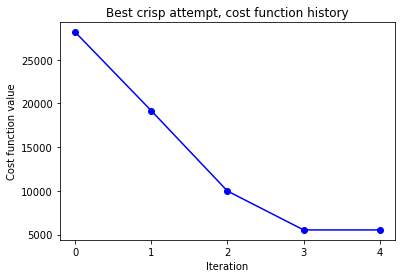

In [24]:
plt.title("Best crisp attempt, cost function history")
plt.xlabel("Iteration")
plt.ylabel("Cost function value")
xticks_list = range(0, n_iter, 1)
plt.xticks(xticks_list)
plt.plot(cost_value_history, 'bo-')

In [25]:
paleta = col.LinearSegmentedColormap.from_list(
        'my_colors', ['#ff0000', '#00ff00', '#0000ff'])

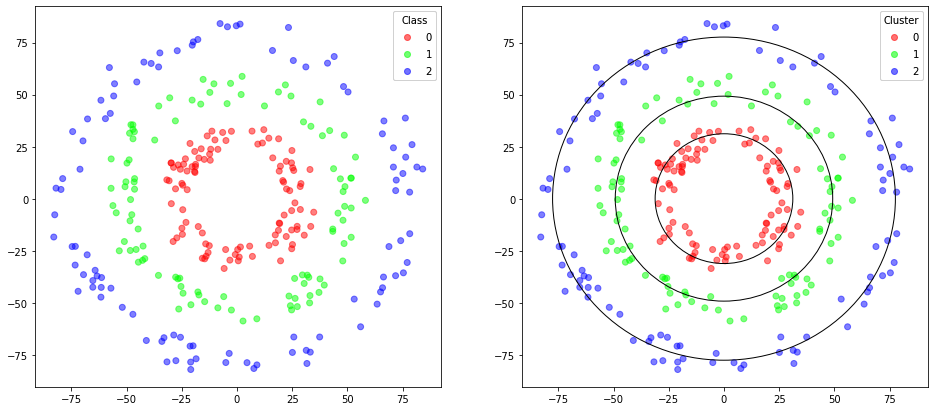

In [56]:
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,7))
plt.subplot(1, 2, 1)
scatter = ax[0].scatter(x=X[:,0], y=X[:,1], c=y, alpha=0.5, cmap=paleta)
my_legend = ax[0].legend(*scatter.legend_elements(), loc="upper right", title="Class")
ax[0].add_artist(my_legend)
plt.subplot(1, 2, 2)
scatter = ax[1].scatter(x=X[:,0], y=X[:,1], c=best_cluster_labels, alpha=0.5, cmap=paleta)
for r in fuzzy_best_theta_vector:
    cir = plt.Circle((0, 0), r, color='k',fill=False)
    ax[1].add_patch(cir)
my_legend = ax[1].legend(*scatter.legend_elements(), loc="upper right", title="Cluster")
ax[1].add_artist(my_legend)

It seems that we have a perfect clustering. 
The contingency table will tell us more details

In [27]:
best_contingency_matrix = contingency_matrix(labels_true=y, labels_pred=best_cluster_labels)

In [28]:
def pretty_print_cm(cm: np.ndarray, true_classes: list):
    line = '          '
    for j in range(0, cm.shape[1]):
        line = line + (' Cluster {:2}'.format(j))
    print(line)
    for i, row in enumerate(cm):
        line = 'Class {:2}: '.format(int(true_classes[i])) + ''.join(''.join(['{:11}'.format(element) for element in row]))
        print(line)

In [29]:
pretty_print_cm(cm=best_contingency_matrix, true_classes=y_classes)

           Cluster  0 Cluster  1 Cluster  2
Class  0:         100          0          0
Class  1:           0        100          0
Class  2:           0          0        100


It seems that there are not misclassified samples... hip, hip, hurra!

In [30]:
best_v_measure = v_measure_score(labels_true=y, labels_pred=best_cluster_labels)
best_v_measure

1.0

Obtaining the maximum range value from V-measure confirms that we have obtained a perfect clustering solution.

#### Fuzzy clustering

The *Fuzzy c-Means* (FCM) algorithm is also implemented.
Let's see how well it works.

Fix a random seed for an easier debugging

In [53]:
random.seed(24)

In [54]:
q_list = [1.5, 1.75, 2, 2.5]

*** Best attempt with q=1.5 ***
Obtained clustering labels frequencies: (array([0, 1, 2]), array([100, 100, 100]))
Obtained clustering definitons (radius): [[77.67580518 29.20091984 54.35483137]]
Cost value history: [57719.43702668  5861.01240173  5844.54636755  5844.53976345
  5844.53975982]
Best cost value: 5844.5398



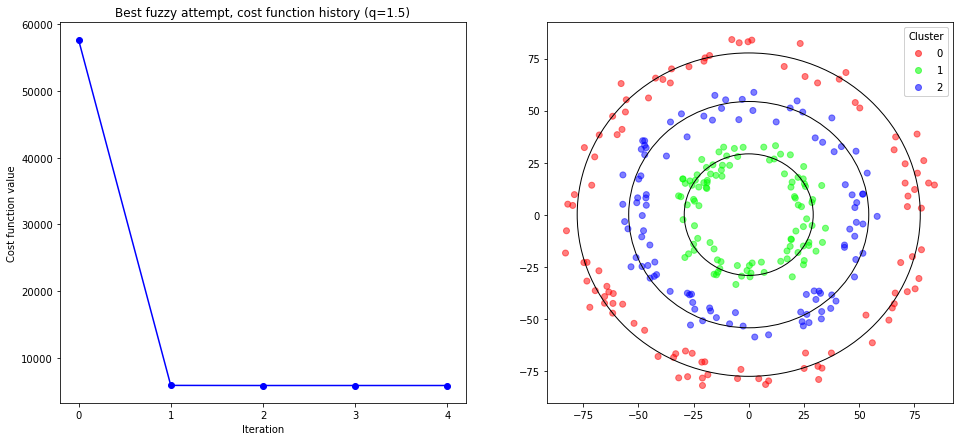

*** Best attempt with q=1.75 ***
Obtained clustering labels frequencies: (array([0, 1, 2]), array([100, 100, 100]))
Obtained clustering definitons (radius): [[28.39218789 49.09808831 77.9397063 ]]
Cost value history: [24264.82758075  6441.87488407  6330.22044568  6328.83646319
  6328.81948668  6328.81927954]
Best cost value: 6328.8193



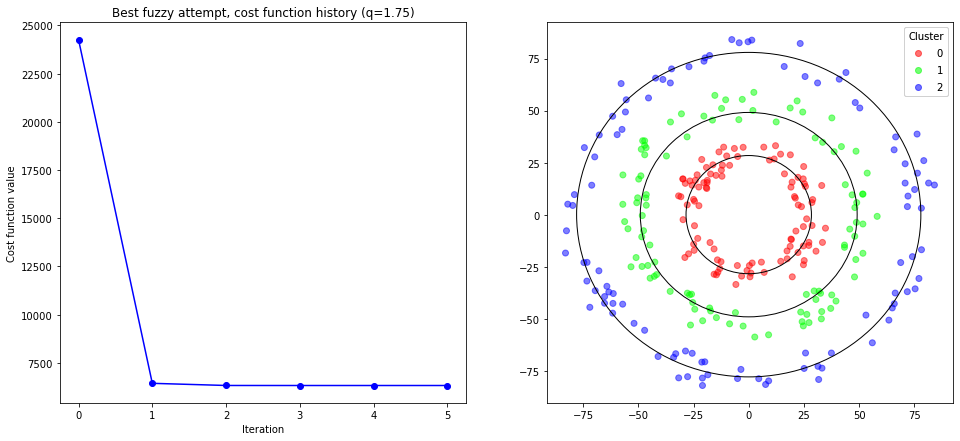

*** Best attempt with q=2 ***
Obtained clustering labels frequencies: (array([0, 1, 2]), array([100, 100, 100]))
Obtained clustering definitons (radius): [[52.16108057 24.72169876 76.29023898]]
Cost value history: [28916.35272301  6428.01410575  6233.35193741  6218.19061592
  6217.02522581  6216.93631553  6216.92955     6216.92903558
  6216.92899647]
Best cost value: 6216.9290



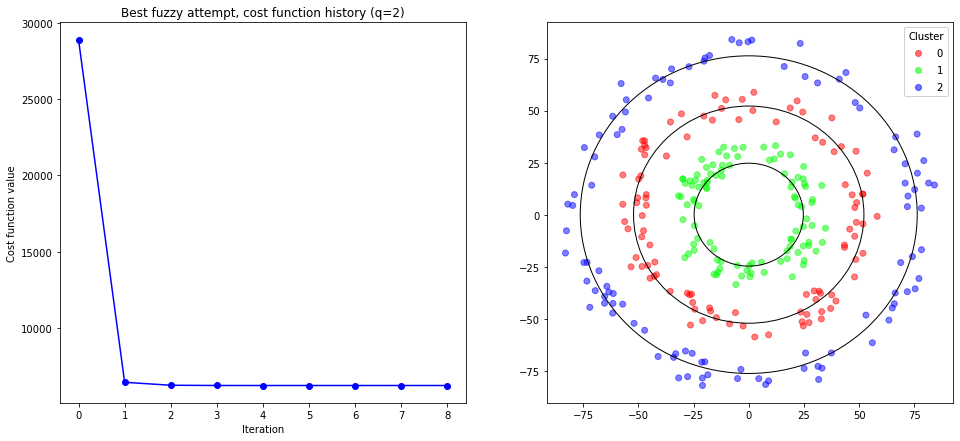

*** Best attempt with q=2.5 ***
Obtained clustering labels frequencies: (array([0, 1, 2]), array([100, 100, 100]))
Obtained clustering definitons (radius): [[77.61501075 31.17344229 49.23426748]]
Cost value history: [33294.25976786  9846.63703582  5469.018805    4922.37847
  4876.15209611  4871.84105701  4871.44260887  4871.40606239
  4871.40271877  4871.4024131 ]
Best cost value: 4871.4024



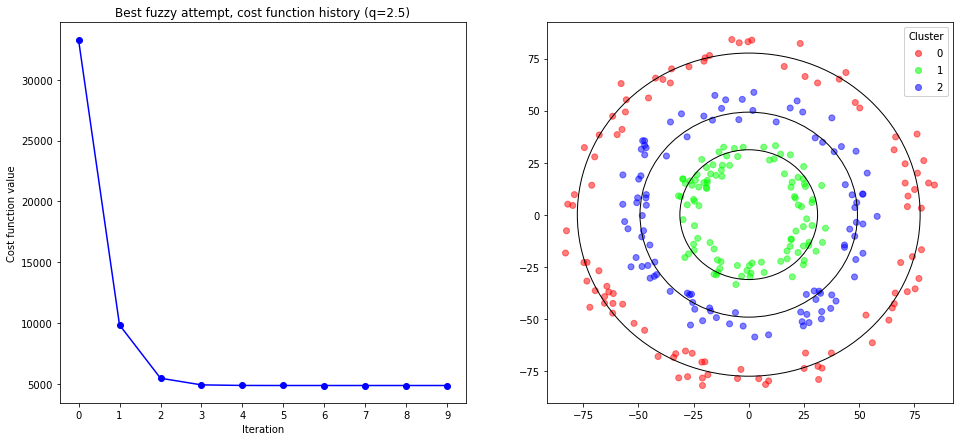

In [55]:
for q in q_list:
    
    [fuzzy_best_cluster_labels, fuzzy_best_theta_vector, fuzzy_cost_value_history, fuzzy_best_cost_value] = \
        do_fuzzy_clust(X=X, M=M, n_iter=n_iter, n_attempts=n_attempts, eps=eps, q=q)
    
    print(f"*** Best attempt with q={q} ***")
    print_report(fuzzy_best_cluster_labels, fuzzy_best_theta_vector, fuzzy_cost_value_history, fuzzy_best_cost_value)
    print("")
    
    _, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,7))
    plt.subplot(1, 2, 1)
    plt.title(f"Best fuzzy attempt, cost function history (q={q})")
    plt.xlabel("Iteration")
    plt.ylabel("Cost function value")
    xticks_list = range(0, n_iter, 1)
    plt.xticks(xticks_list)
    plt.plot(fuzzy_cost_value_history, 'bo-')
    
    scatter = ax[1].scatter(x=X[:,0], y=X[:,1], c=fuzzy_best_cluster_labels, alpha=0.5, cmap=paleta)
    for r in fuzzy_best_theta_vector:
        cir = plt.Circle((0, 0), r, color='k',fill=False)
        ax[1].add_patch(cir)
    my_legend = ax[1].legend(*scatter.legend_elements(), loc="upper right", title="Cluster")
    ax[1].add_artist(my_legend)
    
    plt.show()

It seems that we have a perfect clustering. 
The contingency table will tell us more details

In [34]:
fuzzy_best_contingency_matrix = contingency_matrix(labels_true=y, labels_pred=fuzzy_best_cluster_labels)

In [35]:
pretty_print_cm(cm=fuzzy_best_contingency_matrix, true_classes=y_classes)

           Cluster  0 Cluster  1 Cluster  2
Class  0:         100          0          0
Class  1:           0        100          0
Class  2:           0          0        100


It seems that there are not misclassified samples... hip, hip, hurra!

In [36]:
fuzzy_best_v_measure = v_measure_score(labels_true=y, labels_pred=fuzzy_best_cluster_labels)
fuzzy_best_v_measure

1.0

Obtaining the maximum range value from V-measure confirms that we have obtained a perfect clustering solution.

### Conclusions

Bla, bla, ...